## Greedy-algorithm

In [2]:
'''***************************************************************'''
# 在 Model_version_05_3 的基础上, 添加了 Model_version+05_5 中优化后的子集生成函数，消除了所有主导集
#  Model_version_05_6
import math
import random
import copy
from tqdm.notebook import tqdm
# from os import system
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import datetime
# import io
import numpy as np
import numpy


## 将内容同时输出到命令行和文件中去

In [3]:
## 将内容同时输出到命令行和文件中去
import sys
class Logger:
    def __init__(self, file_name):
        self.terminal = sys.stdout  # 保存原始标准输出
        self.log_file = open(file_name, 'a')  # 打开文件，模式为 append

    def write(self, message):
        self.terminal.write(message)  # 打印到控制台
        self.log_file.write(message)  # 写入文件

    def flush(self):
        # 需要 flush 否则可能输出不会实时写入文件
        self.terminal.flush()
        self.log_file.flush()

    def __del__(self):
        # 在文件关闭前，添加额外的内容
        self.log_file.write("\n" + '*' * 150 + "\n" + '*' * 150 + "\n" + '*' * 150 + "\n")  # 添加自定义分隔符或文本
        self.log_file.close()  # 关闭文件

if False:
    sys.stdout = Logger('output') # 将 sys.stdout 重定向到 Logger 实例
## 将内容同时输出到命令行和文件中去 end

''' 记录当前时间 '''
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(now)

2025-05-10 07:37:17


In [4]:
import numpy as np
from scipy.optimize import milp, Bounds
from scipy.optimize import LinearConstraint

## 检验 贪心算法、线性规划法、布尔代数法、概率随机法之间的效率

#### 程序介绍：
1. 生成一个对于全集 $N$ 的随机数目的随机元素数目子集集合（子集族 $F$）
2. 对该集合采用多种算法, 并评估他们的算法速度

#### 线性规划法 , 布尔代数法  与  概率随机法
* Full_set 需要自己定义
* 注意! 子集中不能出现空集

## 设定全集大小，以及循环次数


In [5]:
# N = 100
N = 18
N = 36
# N = 9

M = 300  
M = 400  
M = 10000  
M = 1000  

### 定义子集生成函数

In [6]:
full_set = list(range(1, N+1))
if len(full_set) < 500:
    print('len(full_set):', len(full_set))
    print('full_set:', full_set)

def check_subset(set_A: set, subsets):  # 检查一个子集 set_A 是否覆盖了 subsets
    for subset in subsets:
        if set_A.isdisjoint(set(subset)):
            return False
    return True

def generate_random_subsets(full_set):  # 待改进：生成的子集集合中存在相同集合
                                        # 已改进：产生的集合中不会出现空集
                                        # 已改进：产生的集合中将不会出现相同子集 (2024/12/12)
                                        # 已改进：不会生成长度为 1 的子集（2024/12/26）
                                        # 已改进：消除掉集合中所有主导集（2024/12/26）
    # num_subsets = random.randint(1, pow(2, len(full_set)))    # Random number of subsets
    # num_subsets = random.randint(1, 15 * len(full_set))
    # num_subsets = random.randint(1, 2 * len(full_set))
    # num_subsets = random.randint(1, 15)
    # num_subsets = random.randint(1, 5 * len(full_set))
    num_subsets = 90
    # num_subsets = 9
    # num_subsets = 18
    # num_subsets = 4

    subsets = []
    for _ in range(num_subsets):
        flag_found = False
        while flag_found == False:
            subset_size = random.randint(2, len(full_set))  # Random subset size
            new_subset = random.sample(full_set, subset_size)  # Random subset
            new_subset = sorted(new_subset)  # 将子集元素排序
            # 如果 new_subset 并未出现在之前的子集中
            flag_found = True
            for element in subsets:
                # 如果 new_subset 为某集合的主导集则同样也跳过
                if new_subset == element or set(element).issubset(new_subset):
                    flag_found = False
                    break
            if flag_found == True:
                subsets.append(new_subset)
    # print('first step subsets:')
    # print(subsets)  # 进行主导集消除前的子集组
    # 最后去除掉主导其他子集的集合
    for element in subsets[:]:
        for other_element in subsets[:]:
            if element == other_element:
                continue
            elif set(other_element).issubset(element):
                subsets.remove(element)
                break
    # print('num_subsets:', len(subsets))
    return subsets

len(full_set): 36
full_set: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


## 将各种计算方法包装成函数，在大循环中调用他们

### 贪心算法：

In [7]:
def Algo_Greedy( subsets ):
    # print('贪心算法开始')
    len_full_set = len(full_set)
    # 现在我们需要将生成的子集格式转换成我们算法中的规范格式(矩阵格式)
    matrix_subsets = []
    for subset in subsets:
        matrix_subset = [0] * len_full_set
        for element in subset:
            matrix_subset[element - 1] = 1
        matrix_subsets.append(matrix_subset)
    # print('matrix_subsets ready')
    # 规范格式下的子集集合的格式(例): [[0, 1, 0, 1, 0], [1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 1, 1], [0, 1, 1, 1, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]
    ''' ！！现在, 我们拥有了规范形式的子集集合！ '''
    ''' 接下来, 我们的算法是：
        1. 找到矩阵中元素值为 1 最多的一列
        2. 去除此列并将该列中值为 1 的子集(行)去除
        3. 重复 1 、 2                        '''
    
    list_index = full_set.copy()    ## full_set 不涉及嵌套结构，普通copy()已经足够 ## 每次选出最大值时, 将这里面的值删除并加入到 set_representative 里
    set_representative = []         # Множество представителей; Hitting Set
    counter = 0
    record = []                     # 记录每一次覆盖时的信息

    while matrix_subsets != []:     # 找出一个 представитель
        record_current_step = []
        counter += 1
        # 1).
        matrix_subsets = numpy.array(matrix_subsets)

        list_index_record = list_index.copy()
        record_current_step.append(list_index_record)
        record_current_step.append(matrix_subsets)
        record.insert(0, record_current_step)
        sum_column = matrix_subsets.sum(axis=0)
        ''' 这里当有多个最大值时，会返回 idx 最小的最大值 '''
        idx_max = np.argmax(sum_column)     # 元素值为 1 最多的一列的 index (由 0 开始)
                                            # 这里将会找到最大值的 index, 当有多个最大值时, 会返回最小的 index
        # 1).
        # 2).
        current_column = matrix_subsets[:, idx_max]
        '''
        1. 删除掉矩阵里相应的 current_column 中值为 1 的序号的行
        2. 删除掉 idx_max 列
        3. 将 idx_max 保存下来作为最小集合成员
        具体实施方法：
        a, 将 current_column 中值为 0 的列添加入新的矩阵(列表)中,
        b, 在新的矩阵中删除每个元素的第 idx_max 元素
        注：a, b 可在同一个循环内进行
        '''
        new_matrix_subsets = []
        for i in range(len(current_column)):
            if current_column[i] == 0:
                new_subset = (matrix_subsets[i,:]).tolist()
                new_subset.pop(idx_max)     # 去除掉第 idx_max 项
                new_matrix_subsets.append(new_subset)
        matrix_subsets = new_matrix_subsets

        set_representative.append(list_index.pop(idx_max.tolist()))
    # print('set_representative:', set_representative)    # ！！初步计划已经完成！！
    set_representative_copy = set_representative.copy()

    # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    '''现在，我们有了 record 和 Greedy 算法得出的结果，我们可以进行检验了'''
    # print('*******************************************************************************************************')


    # print('record:') 
    # for step in record:
    #     print(step)


    set_representative_checked = []     # 检验过后的代表集合


    # print('   type(set_representative): ', type(set_representative))
    # print('   set_representative:', set_representative)
    # print('   type(set_representative_checked):', type(set_representative_checked))


    for step in record:
        check_vector = [0] * len(step[0])
        po = set_representative.pop()
        for element in set_representative_checked:
            for idx, value in enumerate(step[0]):
                if value == element:
                    check_vector[idx] = 1
                    break

        ''' 如果任何子集 S 未能被覆盖，那么我们加入这个 po '''
        flag_add_element = np.any(0 == np.dot(step[1], np.array(check_vector)))
        # 在这里判断是否添加 po 元素进入 set_representative_checked 中
        if flag_add_element:
            set_representative_checked.insert(0, po)


    # print('   set_representative_copy:', set_representative_copy)
    # print('   set_representative_checked:', set_representative_checked)        
    
    
    # print()
    # print('最终结果:')
    # print('set_representative_copy:')
    # print(set_representative_copy)
    # print('set_representative_checked:')
    # print(set_representative_checked)
    # print()
    set_representative_copy.sort()
    set_representative_checked.sort()
    # print('set_representative_copy with offset:')
    # print([x - 1 for x in set_representative_copy])
    # print('set_representative_checked with offset:')
    # print([x - 1 for x in set_representative_checked], '    min len:', len(set_representative_checked))


    # print('set_representative_checked:', set_representative_checked)
    
    
    minlen_greddy_algo = set_representative_checked
    # print('贪心算法结束')
    return minlen_greddy_algo


### 贪心算法2.0：（实现 90%）


##### 辅助函数

In [8]:
''' 检查矩阵的某一列是否是 主导元 '''
def check_has_dominant(matrix, column_idx):
    
    sum_matrix = np.sum(matrix, axis=0)
    print( sum_matrix )
    print()
    flag_has_dominant = False
    rows = matrix[matrix[:, column_idx] == 1]
    print(rows)
    
    for row in rows:
        row_copy = row.copy()
        row_copy[column_idx] = 0    ## 忽略 column_idx 位，相当于跳过
        print('row_copy:', row_copy)

        sum_matrix_mask = sum_matrix[row_copy == 1]

        # check = np.all(np.sum(matrix, axis=0)[row_copy == 1] == 1)
        check = np.all(sum_matrix[row_copy == 1] == 1)
        print(check)

        print( 'sum_matrix_mask:',  sum_matrix_mask)
        print( 'sum_matrix_mask.size:',  sum_matrix_mask.size)
        if check and sum_matrix_mask.size > 0:  
            return True
    return False

def check_has_dominant(matrix, column_idx):
    sum_matrix = np.sum(matrix, axis=0)
    rows = matrix[matrix[:, column_idx] == 1]       ## 这里的 rows 是一个浅拷贝
    rows[ : , column_idx] = 0                       ## 一次性将 column_idx 列置为 0
    
    for row in rows:

        sum_matrix_mask = sum_matrix[row == 1]
        if sum_matrix_mask.size == 0:
            continue
        check = np.all(sum_matrix_mask == 1)

        if check:
            return True
    return False
    

test_matrix_1 = [
    [1,1,0,0,0,0],
    [1,0,1,0,1,0],
    [0,0,1,0,0,1],
    [0,1,0,1,0,0]
]
test_matrix_2 = [
    [1,0,1,0,0],
    [0,1,0,0,1],
    [1,1,0,0,0],
    [0,0,1,1,0]
]
test_matrix_3 = [
    [0,0,0,1,1,1],
    [1,1,0,0,0,0],
    [0,1,1,0,0,0],
    [1,0,1,1,0,0]
]
test_matrix_4 = [
    [0,1,0,0,0,1],
    [1,0,1,0,0,0],
    [1,1,0,0,1,0],
    [0,0,1,1,0,0]
]
test_matrix_5 = [
    [1,0,1,0,0,0],
    [0,1,0,1,0,1],
    [0,0,1,1,0,0],
    [1,0,0,1,0,1],
    [0,1,1,0,0,0],
    [1,1,0,0,0,1]
]
test_matrix_6 = [
    [1,1,0,0,0,0],
    [1,0,1,0,1,0],
    [0,0,1,0,0,0],
    [0,1,0,1,0,0]
]
assert check_has_dominant(np.array(test_matrix_1), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_1), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_1), 3 - 1) == True
assert check_has_dominant(np.array(test_matrix_1), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_1), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_1), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_2), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_2), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_2), 3 - 1) == True
assert check_has_dominant(np.array(test_matrix_2), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_2), 5 - 1) == False

assert check_has_dominant(np.array(test_matrix_3), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 2 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 3 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 4 - 1) == True
assert check_has_dominant(np.array(test_matrix_3), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_4), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_4), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_4), 3 - 1) == True
assert check_has_dominant(np.array(test_matrix_4), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_4), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_4), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_5), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 2 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 3 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_6), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_6), 3 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 6 - 1) == False


# print('Result:', result)

### 贪心算法循环递归函数

In [9]:
''' greedy_core 返回计算出的命中集（可能不是最小） '''
def greedy_core( matrix_subsets, record, set_representative, list_index, counter ):  ## matrix_subsets: np.array    record: list    set_representative: list    list_index: list    counter: int
    

    # print('type(matrix_subsets):', type(matrix_subsets), 
    #       'type(record):', type(record), 
    #       'type(set_representative):', type(set_representative), 
    #       'type(list_index):', type(list_index), 
    #       'type(counter):', type(counter))
    
    
    ## matrix_subsets, record 需要 deepcopy
    flag_recursion = False
    while matrix_subsets.size > 0 and not flag_recursion:
        record_current_step = []
        counter += 1

        list_index_record = list_index.copy()
        record_current_step.append(list_index_record)
        record_current_step.append(matrix_subsets)
        record.insert(0, record_current_step)

        sum_column = matrix_subsets.sum(axis=0)
        ''' 找出最大值的 idx，可以是多个 '''
        max_value = sum_column.max()                            # 求出最大值
        indices_all_max = np.where(sum_column == max_value)[0]  # 求出所有最大值 idx
        
        if len(indices_all_max) == 1 or max_value == 1:
            ''' 如果只有一个最大值，或者只剩下为1的项
            (对于为1的项实际上我们可以任选其一，因此作为只有一个最大值的情况处理) '''
            ''' 对于最大值仅仅为 1 的情况，在这种情况下我们确实可以随意选择一个 '''
        # ''' 暂时先不管 ''' ## 出现了问题，还是需要注意的
        # if len(indices_all_max) == 1:   


            # print('只有一个最大值')


            idx_max = indices_all_max[0]
            current_column = matrix_subsets[:, idx_max]

            new_matrix_subsets = []
            for i in range(len(current_column)):
                if current_column[i] == 0:
                    new_subset = (matrix_subsets[i,:]).tolist()
                    new_subset.pop(idx_max)     # 去除掉第 idx_max 项
                    new_matrix_subsets.append(new_subset)
            matrix_subsets = new_matrix_subsets
                
            set_representative.append(list_index.pop(idx_max.tolist()))
        else:
            ''' 有多个最大值 '''


            # print('有多个最大值')
            
            
            flag_not_dominant = True # 不存在主导元
            # 对于每个 idx 检查是否是 dominant
            dominant_list = [check_has_dominant(matrix_subsets, i) for i in indices_all_max]
            

            # print('max_value:', max_value,'   dominant_list:', dominant_list, '   all_dominant:', indices_all_max + 1)


            if not any(dominant_list):  # 如果全部都为 False ==> 不存在主导元 ==> 递归
                flag_recursion = True

                ''' 需要递归部分的代码尚需要补充 '''
                ''' 如果所有都为 False ==> 没有主导元，那么，我们只好将所有可能的选择都测试一遍 '''
                ''' 我们递归的运行所有 具有最大值 的 idx 被选出的情况 '''

                ''' 这里我们运行完所有具有最大值的情况后，我们将选择出最小的 set_representative 并且返回他 '''
                all_set_representative = [] # 首先保存for循环中所有返回的 set_representative
                for idx_max in indices_all_max:
                    ''' 跟只有一个最大值的情况一样，首先先做排除操作，然后执行递归进行下一轮 ''' 

                    matrix_subsets_copy      = matrix_subsets.copy()
                    record_copy              = copy.deepcopy(record)
                    set_representative_copy  = copy.deepcopy(set_representative)
                    list_index_copy          = copy.deepcopy(list_index)
                    counter_copy             = counter


                    current_column = matrix_subsets_copy[:, idx_max]
                    
                    new_matrix_subsets = []
                    # for i in range(len(current_column)):
                    #     if current_column[i] == 0:
                    for i, v in enumerate( current_column ):
                        if v == 0:
                            new_subset = (matrix_subsets_copy[i,:]).tolist()
                            new_subset.pop(idx_max)                 # 去除掉第 idx_max 项
                            new_matrix_subsets.append(new_subset)
                    matrix_subsets_copy = np.array(new_matrix_subsets)
                        
                    # set_representative_copy.append(list_index_copy.pop(idx_max.tolist()))
                    set_representative_copy.append(list_index_copy.pop(idx_max))

                    result_set = greedy_core(matrix_subsets_copy, 
                                             record_copy, set_representative_copy, 
                                             list_index_copy, counter_copy)
                    all_set_representative.append(result_set)
                    
                best = min(all_set_representative, key=len)


                # print('type(best):', type(best))


                return best
                assert False
                break                                           # 退出 while 循环

            ''' 有一个或多个主导元 '''
            # 删除所有主导元
            indices_all_dominant = indices_all_max[dominant_list]

            columns = matrix_subsets[:, indices_all_dominant]   # 多列
            current_column = np.sum(columns, axis=1)            # 通过求和合并为1列
            
            new_matrix_subsets = []
            for i in range(len(current_column)):
                if current_column[i] == 0:  # 保留值为0的行
                    # new_subset = (matrix_subsets[i,:]).tolist()
                    row = matrix_subsets[i,:]
                    row_new = np.delete(row, indices_all_dominant)
                    new_matrix_subsets.append(row_new.tolist())
            matrix_subsets = new_matrix_subsets
   

            first_time_not_add = True
            for idx in sorted(indices_all_dominant, reverse=True):
                # 这样 pop(idx) 就不会影响比它小的那些索引了
                set_representative.append(list_index.pop(idx))
                ''' 额外在 record 中添加 len(indices_all_dominant) - 1 次记录 '''
                ''' 这样做的目的是让在进行 record 时直接将这些主导元保留 '''
                if first_time_not_add:          # 第一次不进行添加，因为在 while 循环开始时添加过一次
                    first_time_not_add = False
                else:
                    list_index_record = list_index.copy()
                    record_current_step.append(list_index_record)
                    record_current_step.append(matrix_subsets)
                    record.insert(0, record_current_step)
                    
            # set_representative.append(list_index.pop(idx_max.tolist()))

        matrix_subsets = np.array(matrix_subsets)

    # if not flag_recursion:
    # 检验暂时不做
    set_representative_copy = set_representative.copy()

    # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    '''现在，我们有了 record 和 Greedy 算法得出的结果，我们可以进行检验了'''
    # print('*******************************************************************************************************')

    ''' 这里的检查逻辑可以进行优化 '''


    # print('record:') 
    # for re in record:
    #     print(re)

        
    set_representative_checked = []


    # print('   type(set_representative): ', type(set_representative))
    # print('   set_representative:', set_representative)
    # print('   type(set_representative_checked):', type(set_representative_checked))


    for step in record:
        check_vector = [0] * len(step[0])
        po = set_representative.pop()
        for element in set_representative_checked:
            for idx, value in enumerate(step[0]):
                if value == element:
                    check_vector[idx] = 1
                    break
        
        flag_add_element = np.any(0 == np.dot(step[1], np.array(check_vector)))
        # 判断是否将 po 添加进 set_representative_checked 中
        if flag_add_element:
            set_representative_checked.insert(0, po)
                

    # print('   set_representative_copy:', set_representative_copy)
    # print('   set_representative_checked:', set_representative_checked)


    return set_representative_checked
    # return set_representative_copy
    print(set_representative_copy)

    return len(set_representative_copy)


### Greedy 2.0 算法接口

In [10]:
def Algo_Greedy20( subsets ):
    ''' 验证结果的方法: 
    1. 判断是否是 Hitting Set, 即是否与子集族F的每个子集S都有交点;
    2. 检查结果的长度是否与 LinearProgramming 的结果相同或接近 '''
    # print('贪心算法开始')
    len_full_set = len(full_set)
    # 现在我们需要将生成的子集格式转换成我们算法中的规范格式(矩阵格式)
    matrix_subsets = []
    for subset in subsets:
        matrix_subset = [0] * len_full_set
        for element in subset:
            matrix_subset[element - 1] = 1
        matrix_subsets.append(matrix_subset)
    # 规范格式下的子集集合的格式(例): [[0, 1, 0, 1, 0], [1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 1, 1], [0, 1, 1, 1, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]
    ''' ！！现在, 我们拥有了规范形式的子集集合！ '''
    ''' 接下来, 我们的算法是：
        1. 找到矩阵中元素值为 1 最多的一列
        2. 去除此列并将该列中值为 1 的子集(行)去除
        3. 重复 1 、 2                        '''
    
    list_index = full_set.copy()    ## full_set 不涉及嵌套结构，普通copy()已经足够 ## 每次选出最大值时, 将这里面的值删除并加入到 set_representative 里
    set_representative = []         # Множество представителей; Hitting Set
    counter = 0
    record = []                     # 记录每一次覆盖时的信息

    
    result_set_representative = greedy_core( np.array(matrix_subsets), record, set_representative, list_index, counter )            # 使用 np.array 传值
    

    # print('result_set_representative:', result_set_representative)
    
    
    min_len = len(result_set_representative)
    
    
    # print('结束')
    
    
    return min_len


### Greedy 3.0      N = 18      错误率 0.09%;        太慢，还没能找出全部解的速度的四倍快

In [11]:
def greedy_core_30( matrix_subsets, record, set_representative, list_index, counter ):  ## matrix_subsets: np.array    record: list    set_representative: list    list_index: list    counter: int
    

    # print('type(matrix_subsets):', type(matrix_subsets), 
    #       'type(record):', type(record), 
    #       'type(set_representative):', type(set_representative), 
    #       'type(list_index):', type(list_index), 
    #       'type(counter):', type(counter))
    
    
    ## matrix_subsets, record 需要 deepcopy
    flag_recursion = False
    while matrix_subsets.size > 0 and not flag_recursion:
        record_current_step = []
        counter += 1

        list_index_record = list_index.copy()
        record_current_step.append(list_index_record)
        record_current_step.append(matrix_subsets)
        record.insert(0, record_current_step)

        sum_column = matrix_subsets.sum(axis=0)
        ''' 找出最大值的 idx, 可以是多个 '''
        max_value = sum_column.max()                            # 求出最大值
        indices_all_max = np.where(sum_column == max_value)[0]  # 求出所有最大值 idx
        
        # if len(indices_all_max) == 1 or max_value == 1:
        #     ''' 如果只有一个最大值，或者只剩下为1的项
        #     (对于为1的项实际上我们可以任选其一，因此作为只有一个最大值的情况处理) '''
        #     ''' 对于最大值仅仅为 1 的情况，在这种情况下我们确实可以随意选择一个 '''
        # ''' 暂时先不管 ''' ## 出现了问题，还是需要注意的
        # ''' 这个很有必要 严格确保只有当仅有一个最大值时，才执行简单挑选!!! '''
        if len(indices_all_max) == 1:   


            # print('只有一个最大值')


            idx_max = indices_all_max[0]
            current_column = matrix_subsets[:, idx_max]

            new_matrix_subsets = []
            for i in range(len(current_column)):
                if current_column[i] == 0:
                    new_subset = (matrix_subsets[i,:]).tolist()
                    new_subset.pop(idx_max)     # 去除掉第 idx_max 项
                    new_matrix_subsets.append(new_subset)
            matrix_subsets = new_matrix_subsets
                
            set_representative.append(list_index.pop(idx_max.tolist()))
        else:
            ''' 有多个最大值 '''


            # print('有多个最大值')
            
            
            flag_not_dominant = True # 不存在主导元
            # 对于每个 idx 检查是否是 dominant
            dominant_list = [check_has_dominant(matrix_subsets, i) for i in indices_all_max]
            

            # print('max_value:', max_value,'   dominant_list:', dominant_list, '   all_dominant:', indices_all_max + 1)


            # if not any(dominant_list):  # 如果全部都为 False ==> 不存在主导元 ==> 递归
            ''' 改为：对所有最大值可能进行计算 '''
            if True:                    
                flag_recursion = True

                ''' 需要递归部分的代码尚需要补充 '''
                ''' 如果所有都为 False ==> 没有主导元，那么，我们只好将所有可能的选择都测试一遍 '''
                ''' 我们递归的运行所有 具有最大值 的 idx 被选出的情况 '''

                ''' 这里我们运行完所有具有最大值的情况后，我们将选择出最小的 set_representative 并且返回他 '''
                all_set_representative = [] # 首先保存for循环中所有返回的 set_representative
                for idx_max in indices_all_max:
                    ''' 跟只有一个最大值的情况一样，首先先做排除操作，然后执行递归进行下一轮 ''' 

                    matrix_subsets_copy      = matrix_subsets.copy()
                    record_copy              = copy.deepcopy(record)
                    set_representative_copy  = copy.deepcopy(set_representative)
                    list_index_copy          = copy.deepcopy(list_index)
                    counter_copy             = counter


                    current_column = matrix_subsets_copy[:, idx_max]
                    
                    new_matrix_subsets = []
                    # for i in range(len(current_column)):
                    #     if current_column[i] == 0:
                    for i, v in enumerate( current_column ):
                        if v == 0:
                            new_subset = (matrix_subsets_copy[i,:]).tolist()
                            new_subset.pop(idx_max)                 # 去除掉第 idx_max 项
                            new_matrix_subsets.append(new_subset)
                    matrix_subsets_copy = np.array(new_matrix_subsets)
                        
                    # set_representative_copy.append(list_index_copy.pop(idx_max.tolist()))
                    set_representative_copy.append(list_index_copy.pop(idx_max))

                    result_set = greedy_core_30(matrix_subsets_copy, 
                                             record_copy, set_representative_copy, 
                                             list_index_copy, counter_copy)
                    all_set_representative.append(result_set)
                    
                best = min(all_set_representative, key=len)


                # print('type(best):', type(best))


                return best
                assert False
                break                                           # 退出 while 循环

            ''' 有一个或多个主导元 '''
            # 删除所有主导元
            indices_all_dominant = indices_all_max[dominant_list]

            columns = matrix_subsets[:, indices_all_dominant]   # 多列
            current_column = np.sum(columns, axis=1)            # 通过求和合并为1列
            
            new_matrix_subsets = []
            for i in range(len(current_column)):
                if current_column[i] == 0:  # 保留值为0的行
                    # new_subset = (matrix_subsets[i,:]).tolist()
                    row = matrix_subsets[i,:]
                    row_new = np.delete(row, indices_all_dominant)
                    new_matrix_subsets.append(row_new.tolist())
            matrix_subsets = new_matrix_subsets
   

            first_time_not_add = True
            for idx in sorted(indices_all_dominant, reverse=True):
                # 这样 pop(idx) 就不会影响比它小的那些索引了
                set_representative.append(list_index.pop(idx))
                ''' 额外在 record 中添加 len(indices_all_dominant) - 1 次记录 '''
                ''' 这样做的目的是让在进行 record 时直接将这些主导元保留 '''
                if first_time_not_add:          # 第一次不进行添加，因为在 while 循环开始时添加过一次
                    first_time_not_add = False
                else:
                    list_index_record = list_index.copy()
                    record_current_step.append(list_index_record)
                    record_current_step.append(matrix_subsets)
                    record.insert(0, record_current_step)
                    
            # set_representative.append(list_index.pop(idx_max.tolist()))

        matrix_subsets = np.array(matrix_subsets)

    # if not flag_recursion:
    # 检验暂时不做
    set_representative_copy = set_representative.copy()

    # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    '''现在，我们有了 record 和 Greedy 算法得出的结果，我们可以进行检验了'''
    # print('*******************************************************************************************************')

    ''' 这里的检查逻辑可以进行优化 '''


    # print('record:') 
    # for re in record:
    #     print(re)

        
    set_representative_checked = []


    # print('   type(set_representative): ', type(set_representative))
    # print('   set_representative:', set_representative)
    # print('   type(set_representative_checked):', type(set_representative_checked))


    for step in record:
        check_vector = [0] * len(step[0])
        po = set_representative.pop()
        for element in set_representative_checked:
            for idx, value in enumerate(step[0]):
                if value == element:
                    check_vector[idx] = 1
                    break
        
        flag_add_element = np.any(0 == np.dot(step[1], np.array(check_vector)))
        # 判断是否将 po 添加进 set_representative_checked 中
        if flag_add_element:
            set_representative_checked.insert(0, po)
                

    # print('   set_representative_copy:', set_representative_copy)
    # print('   set_representative_checked:', set_representative_checked)


    return set_representative_checked

In [12]:
def Algo_Greedy30( subsets ):
    ''' 验证结果的方法: 
    1. 判断是否是 Hitting Set, 即是否与子集族F的每个子集S都有交点;
    2. 检查结果的长度是否与 LinearProgramming 的结果相同或接近 '''
    # print('贪心算法开始')
    len_full_set = len(full_set)
    # 现在我们需要将生成的子集格式转换成我们算法中的规范格式(矩阵格式)
    matrix_subsets = []
    for subset in subsets:
        matrix_subset = [0] * len_full_set
        for element in subset:
            matrix_subset[element - 1] = 1
        matrix_subsets.append(matrix_subset)
    # 规范格式下的子集集合的格式(例): [[0, 1, 0, 1, 0], [1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 1, 1], [0, 1, 1, 1, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]
    ''' ！！现在, 我们拥有了规范形式的子集集合！ '''
    ''' 接下来, 我们的算法是：
        1. 找到矩阵中元素值为 1 最多的一列
        2. 去除此列并将该列中值为 1 的子集(行)去除
        3. 重复 1 、 2                        '''
    
    list_index = full_set.copy()    ## full_set 不涉及嵌套结构，普通copy()已经足够 ## 每次选出最大值时, 将这里面的值删除并加入到 set_representative 里
    set_representative = []         # Множество представителей; Hitting Set
    counter = 0
    record = []                     # 记录每一次覆盖时的信息

    
    result_set_representative = greedy_core_30( np.array(matrix_subsets), record, set_representative, list_index, counter )            # 使用 np.array 传值
    

    # print('result_set_representative:', result_set_representative)
    
    
    # print('结束')
    
    
    return result_set_representative

### Greedy 4.0 (过于缓慢); 对Greedy 3.0 产生的结果，取其中每一个作为首次取出元，再进行一次

In [13]:
def greedy_core_40( matrix_subsets, record, set_representative, list_index, counter ):  ## matrix_subsets: np.array    record: list    set_representative: list    list_index: list    counter: int
    
    # print('type(matrix_subsets):', type(matrix_subsets), 
    #       'type(record):', type(record), 
    #       'type(set_representative):', type(set_representative), 
    #       'type(list_index):', type(list_index), 
    #       'type(counter):', type(counter))
    
    
    ## matrix_subsets, record 需要 deepcopy
    flag_recursion = False
    while matrix_subsets.size > 0 and not flag_recursion:
        record_current_step = []
        counter += 1

        list_index_record = list_index.copy()
        record_current_step.append(list_index_record)
        record_current_step.append(matrix_subsets)
        record.insert(0, record_current_step)

        sum_column = matrix_subsets.sum(axis=0)
        ''' 找出最大值的 idx, 可以是多个 '''
        max_value = sum_column.max()                            # 求出最大值
        indices_all_max = np.where(sum_column == max_value)[0]  # 求出所有最大值 idx
        

        # 求出次大值
        filtered = sum_column[sum_column != max_value]
        if len(filtered) > 0:
            second_max_value = filtered.max()
            indices_all_second_max = np.where(sum_column == second_max_value)[0]
        else:
            second_max_value = None
            indices_all_second_max = np.array([], dtype=int)


        # if len(indices_all_max) == 1 or max_value == 1:
        #     ''' 如果只有一个最大值，或者只剩下为1的项
        #     (对于为1的项实际上我们可以任选其一，因此作为只有一个最大值的情况处理) '''
        #     ''' 对于最大值仅仅为 1 的情况，在这种情况下我们确实可以随意选择一个 '''
        # ''' 暂时先不管 ''' ## 出现了问题，还是需要注意的
        # ''' 这个很有必要 严格确保只有当仅有一个最大值时，才执行简单挑选!!! '''
        if len(indices_all_max) == 1:   


            # print('只有一个最大值')


            idx_max = indices_all_max[0]
            current_column = matrix_subsets[:, idx_max]

            new_matrix_subsets = []
            for i in range(len(current_column)):
                if current_column[i] == 0:
                    new_subset = (matrix_subsets[i,:]).tolist()
                    new_subset.pop(idx_max)     # 去除掉第 idx_max 项
                    new_matrix_subsets.append(new_subset)
            matrix_subsets = new_matrix_subsets
                
            set_representative.append(list_index.pop(idx_max.tolist()))
        else:
            ''' 有多个最大值 '''


            # print('有多个最大值')
            
            
            flag_not_dominant = True # 不存在主导元
            # 对于每个 idx 检查是否是 dominant
            dominant_list = [check_has_dominant(matrix_subsets, i) for i in indices_all_max]
            

            # print('max_value:', max_value,'   dominant_list:', dominant_list, '   all_dominant:', indices_all_max + 1)


            # if not any(dominant_list):  # 如果全部都为 False ==> 不存在主导元 ==> 递归
            ''' 改为：对所有最大值可能进行计算 '''
            if True:                    
                flag_recursion = True

                ''' 需要递归部分的代码尚需要补充 '''
                ''' 如果所有都为 False ==> 没有主导元，那么，我们只好将所有可能的选择都测试一遍 '''
                ''' 我们递归的运行所有 具有最大值 的 idx 被选出的情况 '''

                ''' 这里我们运行完所有具有最大值的情况后，我们将选择出最小的 set_representative 并且返回他 '''
                all_set_representative = [] # 首先保存for循环中所有返回的 set_representative
                # for idx_max in indices_all_max:
                # for idx_max in np.concatenate((indices_all_max, indices_all_second_max)):       # 尝试所有最大值和次最大值组合 
                if indices_all_second_max.size == 0:
                    cycle = list(indices_all_max)
                else:
                    cycle = list(indices_all_max) + list(indices_all_second_max)

                # print('cycle:', cycle)    
                    
                for idx_max in cycle:
                    ''' 跟只有一个最大值的情况一样，首先先做排除操作，然后执行递归进行下一轮 ''' 

                    matrix_subsets_copy      = matrix_subsets.copy()
                    record_copy              = copy.deepcopy(record)
                    set_representative_copy  = copy.deepcopy(set_representative)
                    list_index_copy          = copy.deepcopy(list_index)
                    counter_copy             = counter


                    current_column = matrix_subsets_copy[:, idx_max]
                    
                    new_matrix_subsets = []
                    # for i in range(len(current_column)):
                    #     if current_column[i] == 0:
                    for i, v in enumerate( current_column ):
                        if v == 0:
                            new_subset = (matrix_subsets_copy[i,:]).tolist()
                            new_subset.pop(idx_max)                 # 去除掉第 idx_max 项
                            new_matrix_subsets.append(new_subset)
                    matrix_subsets_copy = np.array(new_matrix_subsets)
                        
                    # set_representative_copy.append(list_index_copy.pop(idx_max.tolist()))
                    set_representative_copy.append(list_index_copy.pop(idx_max))

                    result_set = greedy_core_40(matrix_subsets_copy, 
                                             record_copy, set_representative_copy, 
                                             list_index_copy, counter_copy)
                    all_set_representative.append(result_set)
                    
                best = min(all_set_representative, key=len)


                # print('type(best):', type(best))


                return best
            
            
            ''' 有一个或多个主导元 '''
            # 删除所有主导元
            indices_all_dominant = indices_all_max[dominant_list]

            columns = matrix_subsets[:, indices_all_dominant]   # 多列
            current_column = np.sum(columns, axis=1)            # 通过求和合并为1列
            
            new_matrix_subsets = []
            for i in range(len(current_column)):
                if current_column[i] == 0:  # 保留值为0的行
                    # new_subset = (matrix_subsets[i,:]).tolist()
                    row = matrix_subsets[i,:]
                    row_new = np.delete(row, indices_all_dominant)
                    new_matrix_subsets.append(row_new.tolist())
            matrix_subsets = new_matrix_subsets
   

            first_time_not_add = True
            for idx in sorted(indices_all_dominant, reverse=True):
                # 这样 pop(idx) 就不会影响比它小的那些索引了
                set_representative.append(list_index.pop(idx))
                ''' 额外在 record 中添加 len(indices_all_dominant) - 1 次记录 '''
                ''' 这样做的目的是让在进行 record 时直接将这些主导元保留 '''
                if first_time_not_add:          # 第一次不进行添加，因为在 while 循环开始时添加过一次
                    first_time_not_add = False
                else:
                    list_index_record = list_index.copy()
                    record_current_step.append(list_index_record)
                    record_current_step.append(matrix_subsets)
                    record.insert(0, record_current_step)
                    
            # set_representative.append(list_index.pop(idx_max.tolist()))



        matrix_subsets = np.array(matrix_subsets)

    # if not flag_recursion:
    # 检验暂时不做
    set_representative_copy = set_representative.copy()

    # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    '''现在，我们有了 record 和 Greedy 算法得出的结果，我们可以进行检验了'''
    # print('*******************************************************************************************************')

    ''' 这里的检查逻辑可以进行优化 '''


    # print('record:') 
    # for re in record:
    #     print(re)

        
    set_representative_checked = []


    # print('   type(set_representative): ', type(set_representative))
    # print('   set_representative:', set_representative)
    # print('   type(set_representative_checked):', type(set_representative_checked))


    for step in record:
        check_vector = [0] * len(step[0])
        po = set_representative.pop()
        for element in set_representative_checked:
            for idx, value in enumerate(step[0]):
                if value == element:
                    check_vector[idx] = 1
                    break
        
        flag_add_element = np.any(0 == np.dot(step[1], np.array(check_vector)))
        # 判断是否将 po 添加进 set_representative_checked 中
        if flag_add_element:
            set_representative_checked.insert(0, po)
                

    # print('   set_representative_copy:', set_representative_copy)
    # print('   set_representative_checked:', set_representative_checked)


    return set_representative_checked

In [14]:
def Algo_Greedy40( subsets ):       ## 过于缓慢
    ''' 验证结果的方法: 
    1. 判断是否是 Hitting Set, 即是否与子集族F的每个子集S都有交点;
    2. 检查结果的长度是否与 LinearProgramming 的结果相同或接近 '''
    # print('贪心算法开始')
    len_full_set = len(full_set)
    # 现在我们需要将生成的子集格式转换成我们算法中的规范格式(矩阵格式)
    matrix_subsets = []
    for subset in subsets:
        matrix_subset = [0] * len_full_set
        for element in subset:
            matrix_subset[element - 1] = 1
        matrix_subsets.append(matrix_subset)
    # 规范格式下的子集集合的格式(例): [[0, 1, 0, 1, 0], [1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 1, 1], [0, 1, 1, 1, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]
    ''' ！！现在, 我们拥有了规范形式的子集集合！ '''
    ''' 接下来, 我们的算法是：
        1. 找到矩阵中元素值为 1 最多的一列
        2. 去除此列并将该列中值为 1 的子集(行)去除
        3. 重复 1 、 2                        '''
    
    list_index = full_set.copy()    ## full_set 不涉及嵌套结构，普通copy()已经足够 ## 每次选出最大值时, 将这里面的值删除并加入到 set_representative 里
    set_representative = []         # Множество представителей; Hitting Set
    counter = 0
    record = []                     # 记录每一次覆盖时的信息

    
    result_set_representative = greedy_core_40( np.array(matrix_subsets), record, set_representative, list_index, counter )            # 使用 np.array 传值
    
    return result_set_representative

    # print('ABC')


    # print('result_set_representative:', result_set_representative)


    list_index = full_set.copy()    ## full_set 不涉及嵌套结构，普通copy()已经足够 ## 每次选出最大值时, 将这里面的值删除并加入到 set_representative 里
    set_representative = []         # Множество представителей; Hitting Set
    counter = 0
    record = []
    matrix_subsets = np.array(matrix_subsets)

    ''' 制作 record '''
    record_current_step = []
    list_index_record = list_index.copy()
    record_current_step.append(list_index_record)
    record_current_step.append(matrix_subsets)
    record.insert(0, record_current_step)


    flag_first_not_do = True

    all_set_representative = [result_set_representative] # 首先保存for循环中所有返回的 set_representative
    for ele_representative in result_set_representative:
        
        if flag_first_not_do:
            flag_first_not_do = False
            continue

        ''' 对每一个 element_representative 都将其取出判断是否可行 '''
        ''' 跟只有一个最大值的情况一样，首先先做排除操作，然后执行递归进行下一轮 ''' 

        ''' 将 ele_representative 转为 idx, 有必要 '''
        idx_max = ele_representative - 1    

        # print('ele_representative:', ele_representative, 'type(idx_max):', type(idx_max))

        matrix_subsets_copy      = matrix_subsets.copy()
        record_copy              = copy.deepcopy(record)
        set_representative_copy  = copy.deepcopy(set_representative)
        list_index_copy          = copy.deepcopy(list_index)
        counter_copy             = counter


        current_column = matrix_subsets_copy[:, idx_max]
        
        new_matrix_subsets = []
        for i, v in enumerate( current_column ):
            if v == 0:
                new_subset = (matrix_subsets_copy[i,:]).tolist()
                new_subset.pop(idx_max)                 # 去除掉第 idx_max 项
                new_matrix_subsets.append(new_subset)
        matrix_subsets_copy = np.array(new_matrix_subsets)
            
        set_representative_copy.append(list_index_copy.pop(idx_max))

        result_set = greedy_core_40(matrix_subsets_copy, 
                                    record_copy, set_representative_copy, 
                                    list_index_copy, counter_copy)
        all_set_representative.append(result_set)
        
    best = min(all_set_representative, key=len)   
    # print('result_set_representative:', result_set_representative)
    
    
    # print('结束')
    
    return best
    # return result_set_representative

### 离散线性规划法：（最强方法，瞬间出正确结果，作为基准使用）

In [15]:
def Algo_LinearProgramming( subsets ): 
    # print('线性规划法开始')
    num_full_set = len(full_set)
    # print(full_set)
    num_subsets = len(subsets)
    '''目标: 将子集转化为离散线性优化问题   已完成'''
    c = np.array([1] * num_full_set)
    integrality = np.array([1] * num_full_set)                     # 整数
    bounds = Bounds([0] * num_full_set, [1] * num_full_set)
    def parser(num_full_set, ele):
        arr = [0] * num_full_set
        for i in ele:
            arr[i - 1] = 1
        return arr
    A_array, res_2 = [], []
    for ele in subsets:
        A_array.append(parser(num_full_set, ele))
    # print('A_array:', A_array) # Amazing!
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)   # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界

    constraints = LinearConstraint(A, b_l, b_u)

    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)
    # print('Array Result:', res.x)
    # res_2 = []
    for idx, var in enumerate(res.x):
        # if var == 1.:
        if math.isclose(var, 1.):
            res_2.append(idx)
    # print('Array Result 2: ', res_2, len(res_2))
    # print('线性规划法结束')
    return np.array(res_2) + 1

### 布尔代数法：


In [16]:
from pyeda.inter import *
import pyeda

def Algo_BooleanAlgebra( subsets ):

    print('布尔代数法开始')
    '''构造布尔化简方法解'''
    x = exprvars('x', len(full_set))
    # print(x)
    
    '''子集组列表，由generate_random_subsets()函数生成'''
    
    '''**************************************************************************'''
    '''将子集组转化成布尔表达式'''
    f1 = 1
    print('num_subsets:', len(subsets))
    for subset in tqdm(subsets):
        f2 = 0
        for element in subset:
            f2 = espresso_exprs((f2 | x[element - 1]).to_dnf())[0]
        f1 = espresso_exprs((f1 & f2).to_dnf())[0]
    
    # print('f1:', f1)
    boolean_function = espresso_exprs(f1.to_dnf())[0]
    # print(boolean_function)
    '''从简化后的表达式中挑选出长度最短的项'''
    # print('boolean_function:', boolean_function, type(boolean_function))
    if (type(boolean_function) != pyeda.boolalg.expr.Variable):
        boolean_function = boolean_function.xs
        min_length = boolean_function[0].degree
        str_result = ''  # 存储所有最短的 ДНФ 项
        count = 0
        for i in boolean_function:
            # print('count:', count, '\t', i, i.degree, min_length)
            count += 1
            if type(i) == pyeda.boolalg.expr.AndOp:  # 通常情况下最短元素将会是这种情况
                if i.degree < min_length:
                    min_length = i.degree
                    str_result = str(i.xs)
                elif i.degree == min_length:
                    str_result += ' ' + str(i.xs)
            elif type(i) == pyeda.boolalg.expr.Variable:
                if min_length == 1:
                    str_result += ' (' + str(i) + ')'
                else:
                    min_length = 1
                    str_result = '(' + str(i) + ')'
    else:
        str_result = '(' + str(boolean_function) + ')'
    print('String Result:', str_result)
    print('布尔代数法结束')

### 随机概率法：

In [17]:
def Algo_RandomProbability( subsets ):
    print('概率随机法开始')
    num_full_set = len(full_set)
    num_subsets = len(subsets)
    '''目标: 计算出相应条件下的连续离散优化问题, 其中取值范围为[0, 1]'''
    c = np.array([1] * num_full_set)    # 对 x1 x2 ... xm 求和, 且条件为求 min
    integrality = np.array([0] * num_full_set)                     # 实数变量
    bounds = Bounds([0] * num_full_set, [1] * num_full_set)        # 变量取值边界 (在这个例子里为 0~1之间概率)
    def parser(num_full_set, subset):              # 辅助函数
        arr = [0] * num_full_set
        for i in subset:
            arr[i - 1] = 1
        return arr
    A_array = []
    for i in subsets:                              # 将子集转为线性规划问题的参数
        A_array.append(parser(num_full_set, i))
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)   # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)
    
    print('Array Result:', res.x)       # 获取到了每个概率属于最优解的理论概率
    print(res.fun)

    '''接下来我们进行 N 次猜测: 以 res.x值作为概率确定每个值是否被选中, 并判断得出子集是否满足条件. 最终进行比较, 找到最小的子集'''
    N = 100000    # 进行循环猜测的次数
    '''！！！！！还需要添加的部分: 需要统计在 N 次中, 有多少次不满足要求, 即实际失败率约为多少！！！'''
    min_set = []
    flag_find = False
    for i in (range(N)):
        try_set = []
        len_try_set = 0
        for probability in res.x:
            if probability == 1:
                try_set.append(1)
                len_try_set += 1
            elif random.uniform(0, 1) < probability:  # 随机生成一个0到1之间的数, 判断他是不是小于 probability
                try_set.append(1)
                len_try_set += 1
            else:
                try_set.append(0)
        test_set, test_set_2 = [], []
        for idx, var in enumerate(try_set):
            if var == 1:
                test_set.append(idx + 1)
                test_set_2.append(idx)
        test_set = set(sorted(test_set))
        test_set_2 = set(sorted(test_set_2))
        len_min_set = num_full_set
        '''检测 try_set [] 是否能够满足这个集合'''
        # print(test_set, len_try_set)
        if check_subset(test_set, subsets):
            flag_find = True
            if len(min_set) == 0:
                min_set.append(sorted(test_set_2))
                len_min_set = len(test_set_2)
            elif len(test_set) < len_min_set:
                len_min_set = len(test_set_2)
                min_set = []
                min_set.append(sorted(test_set_2))
            elif len(test_set) == len_min_set:
                flag = True
                for i in min_set:
                    # print('XXX:', i, test_set_2, i == test_set_2)
                    if i == test_set_2:
                        flag = False
                        break
                if flag:
                    min_set.append(sorted(test_set_2))
    if flag_find:
        # print('min_set:', min_set, 'min_len:', len_min_set)
        print('min_set:', np.array(min_set) + 1, 'min_len:', len(min_set[0]))
    else:
        print('min_set:', min_set, 'Not find!')
    print('概率随机法结束')

    return res.x

### 罗蒙诺索夫读书会法 2.6：(使用了一次性从Q_k去除多个子集) (在 combinations_len_k 为空时，提早结束循环)

In [18]:
import time
import itertools

def Algo_LomonosovReading_26( subsets , calculation_time_1 ):   # 子集族通过参数传递
    # print('Lomonosov reading 2.6 算法开始')
    
    def Subsets_List_to_Matrix(subsets):
        boolean_subsets = np.zeros((len(subsets), num_full_set), dtype=bool)
        for i, subset in enumerate(subsets):
            boolean_subsets[i, np.array(subset) - 1] = 1
        return boolean_subsets

    def max_elements_sum_less_than_1(arr):  # 找到scan小于1的最大idx
        sum = 0
        idx = -1
        arr_sorted = np.sort(arr)           # 对数组进行排序，从小到大
        while sum < 1.:
            if math.isclose(sum, 1.):       # 让 sum 严格小于 1., 排除掉因为误差导致的 sum < 1. 情况
                break
            idx += 1
            sum += arr_sorted[idx]
        return idx                          # 返回最多能选取的元素数量

    def parser(num_full_set, subset):   # 辅助函数
        arr = [0] * num_full_set        # 将集合族转为 0 1 矩阵
        for i in subset:                # [2,4,5] => [0,1,0,1,1,0]
            arr[i - 1] = 1
        return arr
    
    start_time = time.time()            # 设定算法计时器
    M_min = 0                           # 最小集合大小
    num_full_set = len(full_set)        # 全集大小
    num_subsets = len(subsets)          # 子集族大小
    # 连续线性规划
    '''目标: 计算出相应条件下的连续优化问题, 其中取值范围为[0, inf]'''
    c = np.array([1] * num_full_set)    # 对 x1 x2 ... xm 求和, 且条件为求 min
    integrality = np.array([0] * num_full_set)  # 实数变量
    bounds = Bounds([0] * num_full_set, [np.inf] * num_full_set)  # 变量取值边界 (在这个例子里为 0~inf之间概率, 即0到正无穷)
    A_array = []
    for i in subsets:  # 将子集转为线性规划问题的参数
        A_array.append(parser(num_full_set, i))
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)  # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)    # 连续线性规划解
    # 连续线性规划 end
    # 判断是否为布尔解
    '''这里需要判断得出的解是否为布尔解, 即所有的 x_i 是否要么 0 要么 1'''
    '''判断得出解是否为布尔解'''
    all_boolean = True
    for ele in res.x:
        if (not math.isclose(ele, 0)) and (not math.isclose(ele, 1)):
            all_boolean = False
            break
    # if all_boolean: # 如果全部元素都是布尔解，那么直接上下界相等
    '''似乎这对于算法并没有加速效果...'''
    # 判断是否为布尔解 end

    # 计算 M_sum_ceil
    '''我们计算出'''
    M_sum = np.sum(res.x)

    if math.isclose(M_sum, round(M_sum)): # 需要考虑微小误差!!!   
        M_sum_ceil = round(M_sum)
    else:
        M_sum_ceil = math.ceil(M_sum)
    
    # print('M_sum', M_sum)
    # print('M_sum_ceil', M_sum_ceil)
    # 计算 M_sum_ceil end

    # 计算 t 值
    h = max_elements_sum_less_than_1(res.x)
    t = num_full_set - h
    if M_sum_ceil == t:
        # print('由于 M_sum_ceil == t, 因此 M^* = t =', t)
        pass
    # print('A:')
    # print(A)
    # print('Subsets_List_to_Matrix:')
    # print(Subsets_List_to_Matrix(subsets))
    # print('From', M_sum_ceil, 'to', t)

    # 判断是否出现了由于误差导致的 M_sum_ceil 大于 t 的情况
    if M_sum_ceil > t:
        if math.isclose(M_sum, t):              # 如果是因为误差导致 M_sum_ceil > t 则没有关系 
            M_sum_ceil = t
            # print('M_sum and t is close, let M_sum_ceil = t ', 'From', M_sum_ceil, 'to', t)
        else:                                   # M_sum_ceil 如果确实大于 t 则属于错误
            # print('Error! M_sum and t is not close')
            # print('M_sum:', M_sum)
            # print('t:', t)
            assert M_sum_ceil <= t              # M_sum_ceil <= t 一切正常，否则就是出现错误
    # 计算 t 值 end
    # print('A:')
    # print(A)
    # print('A.shape:', A.shape)
    # S 矩阵已获得
    A = A.T # 将 A 提前变为 A.T A 的转置
    # print('A.T:')
    # print(A)
    # print('A.shape:', A.shape)

    # print('A_array:')
    # print(A_array)  # A_array : ( len(subsets) , N )  shape: ( F中子集数 , 全集大小 )
    # print('len(A_array):', len(A_array))
    # for i in A_array:
    #     print(len(i))
    # print('len(subsets):', len(subsets))

    result_LOMONOSOV_READING_METHOD = []
    for k in range(M_sum_ceil, t + 1):  # 从 M_sum_ceil 到 t 开始寻找最优 Hitting Set 集合大小 M*
        combinations_len_k = set(itertools.combinations(full_set, k))  # H_k 全集

        ''' 遍历每一个 S 集 '''
        for S in subsets:
            # N_minus_S = set(full_set) - set(S)          
            # N_minus_S_k = set(itertools.combinations(N_minus_S, k))
            
            # N_minus_S_k = set(itertools.combinations(set(full_set) - set(S), k))
            # combinations_len_k -= N_minus_S_k
            
            combinations_len_k -= set(itertools.combinations(set(full_set) - set(S), k))
            if not combinations_len_k:          # 当 combinations_len_k 为空时，立刻终止循环 
                break

        ''' 如果 combinations_len_k 在经过处理后不为空 '''
        if combinations_len_k:
            result_LOMONOSOV_READING_METHOD = list(combinations_len_k)
            break
        

    ''' 记录运算时间 '''
    calculation_time_1_item = time.time() - start_time
    calculation_time_1.append(calculation_time_1_item)    
    
    # print('result_LOMONOSOV_READING_METHOD:')
    # print(result_LOMONOSOV_READING_METHOD)
    result_LOMONOSOV_READING_METHOD = np.array(result_LOMONOSOV_READING_METHOD) - 1            
    # print('Lomonosov reading 2.6 算法结束')
    return result_LOMONOSOV_READING_METHOD

## 循环多次进行检验

In [ ]:
# 对整体进行多次循环, 找到所有较好的例子

greedy_algo_donot_work = []                 # 贪心算法无法找到最小解
greedy20_algo_donot_work = []
greedy_algo_donot_work_difference = []      # 贪心算法无法找到最小解时与最小解的差距
greedy20_algo_donot_work_difference = []
size_of_mini_set = []                       # 统计最小集合的 size
ratio_mini_set_of_greedy = []               # 最优解 / Greedy 算法解
ratio_mini_set_of_greedy20 = []
minlen_greddy_algo = 0
minlen_int_linear_prog = 0
for _ in tqdm(range(M)):                    
    ''' 生成子集族 '''
    subsets = generate_random_subsets(full_set)
    ''' 保留 subsets 的深拷贝，用于检验算法是否修改了 subsets '''
    subsets_COPY = copy.deepcopy(subsets)

    # subsets = [[1, 2, 5], [1, 3], [1, 4], [4, 5], [3, 5], [2, 3, 5]]
    # subsets = [[1, 2, 3, 4, 5, 6], [3], [1, 2, 3, 6], [3, 4, 6], [1, 2, 3, 4, 6]]     # error
    # subsets = [[1, 2, 5, 6], [1, 3, 4, 6], [1, 2, 3, 4, 5, 6], [1, 4], [], [], [1, 3, 5, 6], [1, 2, 3, 4, 5], [4, 5], [], [1, 2, 3, 4, 5, 6], [4], [1, 2], []]    # error
    # subsets = [[]]  # error
    # subsets = [[1, 3, 4, 5, 6], [3, 4], [2, 3, 4, 5, 6], [1, 2, 3, 4, 5], [4], [1], [2], [1, 3, 5], [2, 3, 4, 5, 6], [1, 2, 4, 5, 6], [1, 3], [1, 2, 4, 6], [1, 2, 3, 4, 5, 6]] # slow
    # subsets = [[1, 3, 4, 5], [1, 2, 3, 4, 5, 6], [4], [1, 2, 3, 4, 5, 6], [1, 2, 5, 6], [1, 2, 3, 5, 6], [2, 3, 4, 5, 6], [2, 3], [2, 4], [1, 2, 3, 4, 5], [3, 4, 5, 6], [1, 6], [2], [1, 2, 3, 4, 5], [1, 3, 4]] # slow

    # n = 6 时贪心算法找不到最小值的例子：
    # 20: subsets = [[1, 2, 4, 5, 6], [1], [3], [1, 2, 3, 5, 6], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [2, 4, 6], [1, 3, 5], [1, 3, 4, 5, 6], [2, 3, 4, 5, 6], [1, 2, 3], [2, 3, 5], [4, 6], [1, 2, 3, 5], [4, 5, 6], [2], [1, 2, 4], [2, 3, 4, 6], [1, 2, 3, 6], [2, 4, 5, 6], [1, 2, 4, 5], [5, 6], [3, 6], [2, 4], [3, 5, 6], [1, 5]]
    # 9: subsets = [[2, 6], [4, 5], [1, 3, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 4, 5], [1, 2, 3, 5, 6], [2, 4], [1, 6], [2, 5, 6]]
    # 20: subsets = [[4], [1, 3, 4, 5, 6], [1, 3, 6], [4, 5, 6], [3, 6], [3, 5, 6], [1, 2, 3, 4, 5, 6], [2, 3, 4], [5], [3, 4, 5, 6], [1, 2, 3, 5], [1, 3, 5], [2, 3, 4, 6], [1, 2, 3, 4, 5], [2, 4, 5], [3, 4, 5], [1, 2, 3, 4, 6], [2, 6], [1, 2, 3, 5, 6], [2, 4, 6]]
    
    # subsets = [[1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 57, 61, 65, 67, 68, 69, 72, 73, 74, 76, 77, 79, 81, 82, 86, 87, 88, 90, 91, 93, 94, 96, 97, 98, 99, 100], [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 18, 20, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 57, 58, 60, 62, 64, 65, 67, 68, 69, 70, 71, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 97, 99], [3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 35, 37, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100], [1, 2, 5, 6, 7, 9, 10, 11, 14, 16, 17, 20, 22, 24, 28, 31, 36, 38, 39, 40, 43, 44, 45, 46, 52, 53, 55, 58, 59, 60, 61, 65, 67, 70, 71, 73, 75, 76, 78, 82, 83, 85, 96, 97, 99, 100], [1, 7, 64, 92], [4, 9, 15, 22, 26, 37, 52, 53, 55, 60, 82, 88, 91, 96], [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 52, 53, 56, 58, 59, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100], [1, 10, 13, 15, 19, 21, 22, 23, 27, 28, 31, 35, 46, 49, 54, 57, 63, 65, 71, 74, 75, 76, 77, 83, 86, 93, 95, 99], [3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 24, 25, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 51, 52, 53, 59, 60, 63, 64, 65, 67, 71, 72, 74, 75, 76, 77, 79, 80, 82, 83, 84, 87, 88, 89, 90, 91, 95, 99, 100], [1, 14, 41, 55, 68, 95, 97], [2, 3, 4, 5, 7, 9, 10, 12, 16, 17, 19, 20, 21, 23, 25, 29, 30, 31, 32, 33, 35, 37, 38, 40, 41, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 57, 59, 60, 61, 62, 64, 65, 66, 73, 75, 76, 79, 85, 86, 88, 89, 95, 96, 97, 100]]
    # subsets = [[2, 9, 11, 12, 18], [7, 12, 15], [2, 13], [3, 15], [7, 9, 15, 16, 17], [4, 7, 8, 10, 12, 18], [1, 3, 5, 6, 10, 11, 12, 18], [2, 4, 5, 8, 16], [7, 11], [1, 3, 4, 8, 13, 16, 18], [1, 3, 4, 8, 12, 13, 17], [10, 13]]

    # Greedy 3.0 无法找到最小值
    # subsets = [ [3, 5, 6, 11],
    #             [2, 3, 4, 5, 9, 12, 13, 14, 17, 18],
    #             [8, 10, 12, 15],
    #             [2, 10],
    #             [1, 4, 8, 11, 12, 14, 15, 16, 17],
    #             [10, 14],
    #             [1, 3, 7, 9, 15],
    #             [2, 4, 5, 7, 9, 16, 18],
    #             [1, 2, 11, 13, 16, 17, 18]] 

    # Greedy 4.0 无法找到最小值
    # subsets = [[4, 6, 7, 8, 9, 10, 11], [1, 2, 3, 6, 7, 8, 10, 11, 15, 16, 18], [3, 4, 8], [7, 9, 10, 18], [1, 4, 5, 6, 7, 14, 15], [1, 3, 4, 5, 9, 10, 11, 17, 18], [5, 10, 11, 15, 16, 17, 18], [1, 2, 5, 7, 8, 9, 10, 15], [8, 9, 10, 12, 14, 16], [1, 2, 5, 6, 8, 9, 12, 15], [1, 4, 5, 9, 11, 16, 18], [11, 14], [5, 14, 15, 16, 18], [6, 10, 14, 15]]
    # subsets = [[2, 4, 6, 10, 11, 12, 13, 14, 18], [2, 7, 9, 12, 14, 16], [1, 5, 6, 7, 8, 9, 13, 14, 16, 17], [3, 8, 18], [3, 5, 7, 13, 14, 15, 17], [5, 6, 7, 11, 12, 13, 15, 16, 17], [1, 7, 9, 10, 11, 13], [1, 2, 3, 5, 9, 10, 15, 17], [1, 5, 6, 8, 10, 11, 13, 17], [1, 6, 7, 15], [5, 10, 11, 13, 14, 15, 16], [1, 2, 3, 4, 7, 9, 12, 13], [1, 8, 14, 15]]
    # subsets = [[4, 10, 14, 15, 16, 17, 18], [3, 4, 11, 12, 14, 15, 18], [1, 4, 7, 10, 12, 15, 17, 18], [6, 10, 14, 15, 18], [3, 5, 8, 10, 11, 14, 16], [10, 13], [3, 6, 7, 9, 10, 14, 16, 18], [1, 6, 7, 8, 9, 11, 14, 17, 18], [4, 8, 11, 13], [1, 2, 3, 6, 7, 11, 12, 14, 16], [2, 6, 7, 8, 9, 11, 13, 14, 15, 16], [11, 12, 13]]




    print('subsets =', subsets)
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Random probability
    res_x = Algo_RandomProbability( subsets )
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Linear programming  返回代表集最小长度
    minset_int_linear_prog = Algo_LinearProgramming( subsets )
    minlen_int_linear_prog = len(minset_int_linear_prog)
    print('minset_int_linear_prog (num):', minset_int_linear_prog)
    print('minlen_int_linear_prog:', minlen_int_linear_prog)
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Lomonosov reading 2.6
    minset_lomonosov_algo = np.array(Algo_LomonosovReading_26( subsets, [] )) + 1
    print('Lomonosov:')
    print(minset_lomonosov_algo)
    counter = Counter(minset_lomonosov_algo.flatten())
    p_value = [  counter[key]   for key in full_set]
    print(p_value)
    print('zip:')
    print(list(zip(res_x, p_value)))
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Greedy 
    minset_greddy_algo = Algo_Greedy( subsets )
    minlen_greddy_algo = len(minset_greddy_algo)
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Greedy2.0 
    minset_greddy20_algo = Algo_Greedy40( subsets )
    minlen_greddy20_algo = len(minset_greddy20_algo)
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Boolean algebra
    # '''**************************************************************************'''
    '''*********************************************************************************************************************'''


    # print('minset_greddy_algo:', minset_greddy_algo, '   minset_greddy20_algo:', minset_greddy20_algo)
    # print('minset_int_linear_prog (num):', minset_int_linear_prog)
    # print('minlen_greddy_algo:', minlen_greddy_algo, '   minlen_greddy20_algo:', minlen_greddy20_algo)
    # print('minlen_int_linear_prog:', minlen_int_linear_prog)


    # assert minlen_greddy20_algo <= minlen_greddy_algo       ## 2.0 版本的 Greedy 算法应该一直比 Greedy 的解更优
    assert minlen_greddy20_algo >= minlen_int_linear_prog   ## 2.0 版本的 Greedy 算法不应该小于整数线性规划法

    ''' 如果整数线性优化结果小于贪心算法, 那么将当前 subsets 添加进库 '''
    if minlen_int_linear_prog < minlen_greddy_algo:
        greedy_algo_donot_work.append(subsets)
        greedy_algo_donot_work_difference.append( minlen_greddy_algo - minlen_int_linear_prog )

    if minlen_int_linear_prog < minlen_greddy20_algo:
        greedy20_algo_donot_work.append(subsets)
        greedy20_algo_donot_work_difference.append( minlen_greddy20_algo - minlen_int_linear_prog )   

    size_of_mini_set.append( minlen_int_linear_prog ) # 记录每次的最优解集合大小
    ratio_mini_set_of_greedy.append( minlen_int_linear_prog / minlen_greddy_algo )
    ratio_mini_set_of_greedy20.append( minlen_int_linear_prog / minlen_greddy20_algo )

    ''' 如果 subsets 被修改，立刻报错!!! '''
    assert subsets_COPY == subsets       
    
lenth_list = [len(i) for i in greedy_algo_donot_work]
sorted_first_10_list = sorted(greedy_algo_donot_work, key=len)[:10]  # 排序后长度最短的 10 个

print('sorted_list:')
print(sorted_first_10_list)
print('M:', M)
print('min length:', min(lenth_list), '     percent of not work:', f'({100 * len(greedy_algo_donot_work) / M}%)')
print('min length:', min(lenth_list), '     percent of not work(Greedy20):', f'({100 * len(greedy20_algo_donot_work) / M}%)')
print('number of not work:', len(greedy_algo_donot_work))
print('number of not work:', len(greedy20_algo_donot_work))



  0%|          | 0/1000 [00:00<?, ?it/s]

subsets = [[1, 6, 7, 10, 11, 16, 20, 24, 26, 27, 28, 29, 32, 34, 36], [9, 23, 29, 30], [3, 5, 12, 15, 18, 20, 27, 29, 34], [4, 12, 17, 26, 31, 36], [3, 4, 5, 7, 10, 11, 12, 13, 16, 18, 19, 22, 23, 26, 32, 33], [5, 14, 29], [14, 15, 23], [10, 11, 13, 23, 26, 32, 33, 34], [1, 2, 5, 11, 27, 31, 32, 36], [5, 8, 13, 15, 17, 19], [1, 7, 8, 10, 11, 13, 25, 35], [16, 18, 23, 33, 34], [9, 12, 16, 17, 21, 24, 32, 34, 35, 36], [5, 7, 9, 11, 12, 20, 22, 24, 25, 27, 34], [2, 7, 13, 15, 24, 30, 33], [1, 3, 6, 10, 12, 13, 14, 17, 18, 19, 26, 34, 35], [2, 3, 4, 10, 14, 16, 17, 18, 20, 21, 23, 24, 26], [4, 12, 14, 31], [13, 25, 29, 36], [5, 16, 20], [2, 7, 9, 10, 12, 17, 20, 25, 26, 30, 34, 35, 36], [19, 25], [1, 2, 5, 8, 9, 15, 16, 28, 31, 35, 36], [3, 4, 7, 9, 13, 14, 16, 20, 22, 27, 28, 34, 35, 36], [9, 12, 13, 20, 21, 22, 35], [2, 29], [13, 15, 34], [1, 8, 10, 12, 13, 14, 16, 17, 18, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 34, 35], [5, 6, 8, 9, 10, 17, 21, 22, 25, 26, 31, 36], [7, 8, 11, 13, 14, 17

### 打印无法找到最小值的例子

In [ ]:
for subset in greedy20_algo_donot_work:
    print(subset)
    # print
    # for elem in subset:
    #     print(elem)

In [ ]:
print(subsets)
print()
for sub in subsets:
    print(sub)

[[2, 8], [3, 4, 5, 8, 9], [1, 7, 8, 9]]

[2, 8]
[3, 4, 5, 8, 9]
[1, 7, 8, 9]


# 进行频率统计

In [ ]:
## 进行频率统计
print('总数:', M)
counter = Counter(greedy_algo_donot_work_difference)
print('greedy_algo_donot_work_difference\n贪心算法与最优解差值:', counter)
counter = Counter(size_of_mini_set)
print('size_of_mini_set\n最优解大小统计:', counter)
counter = Counter(ratio_mini_set_of_greedy)
print('ratio_mini_set_of_greedy \n对不同比率进行统计: ', counter)
total = sum(counter.values())
proportions = {k: v / total for k, v in counter.items()}
print('所占比重:', proportions)
print('min(ratio_mini_set_of_greedy) \n最小比率:', min(ratio_mini_set_of_greedy), '   次数：',counter[min(ratio_mini_set_of_greedy)])

总数: 1000
greedy_algo_donot_work_difference
贪心算法与最优解差值: Counter({1: 6})
size_of_mini_set
最优解大小统计: Counter({2: 583, 1: 402, 3: 15})
ratio_mini_set_of_greedy 
对不同比率进行统计:  Counter({1.0: 994, 0.6666666666666666: 6})
所占比重: {1.0: 0.994, 0.6666666666666666: 0.006}
min(ratio_mini_set_of_greedy) 
最小比率: 0.6666666666666666    次数： 6


# 绘制图像

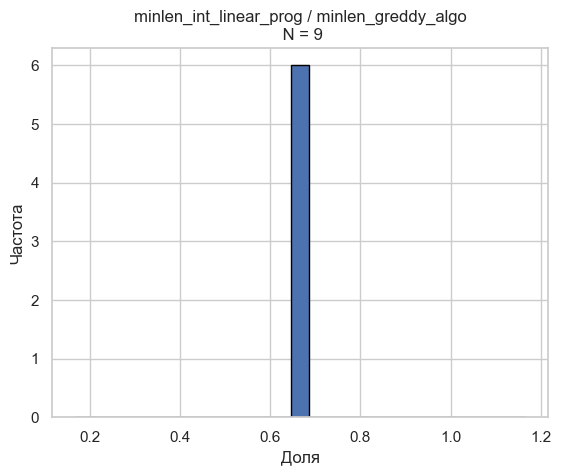

In [ ]:
## 打印频率统计图：
# 设置 Seaborn 风格
sns.set(style="whitegrid")
plt.hist([x for x in ratio_mini_set_of_greedy if x <= 0.9], bins=25, edgecolor='black')  # bins 是分箱数量
plt.title(f'minlen_int_linear_prog / minlen_greddy_algo\n N = {len(full_set)}')
# plt.xlabel('Разница')
plt.xlabel('Доля')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

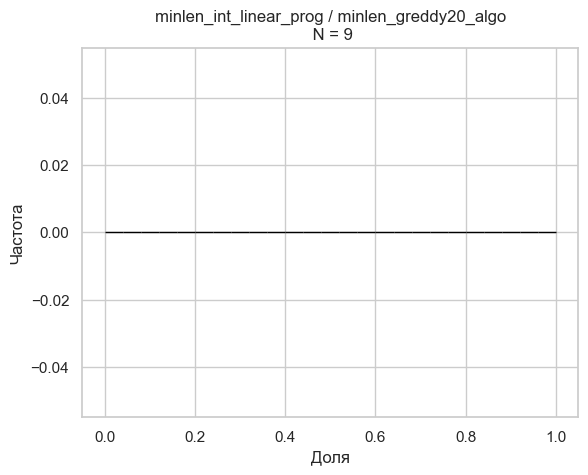

In [ ]:
## 打印频率统计图：
# 设置 Seaborn 风格
sns.set(style="whitegrid")
plt.hist([x for x in ratio_mini_set_of_greedy20 if x <= 0.65], bins=25, edgecolor='black')  # bins 是分箱数量
plt.title(f'minlen_int_linear_prog / minlen_greddy20_algo\n N = {len(full_set)}')
# plt.xlabel('Разница')
plt.xlabel('Доля')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [ ]:
# ## 打印频率统计图：
# # 设置 Seaborn 风格
# sns.set(style="whitegrid")
# # plt.hist(greedy_algo_donot_work_difference, bins=10, edgecolor='black')  # bins 是分箱数量
# plt.hist(size_of_mini_set, bins=10, edgecolor='black')  # bins 是分箱数量
# plt.title(f'Оптимальный размер мини множеств представителей\n N = {len(full_set)}')
# # plt.xlabel('Разница')
# plt.xlabel('Размер')
# plt.ylabel('Частота')
# plt.grid(True)
# plt.show()

## 测试

In [ ]:

subsets_8 = [
    [1,2],
    [1,3],
    [1,4],
    [1,5],
    [2],
    [3],
    [4],
    [5]
]

Algo_Greedy( subsets_8 )

[2, 3, 4, 5]

## 无法通过的例子：

In [ ]:
''' 已修复 '''
subsets = [[36, 44, 69, 72, 78], [1, 2, 5, 6, 7, 9, 10, 11, 15, 17, 19, 21, 27, 32, 35, 37, 38, 39, 40, 45, 50, 52, 54, 58, 60, 61, 63, 69, 70, 71, 76, 78, 79, 82, 84, 90, 93, 99, 100], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 99, 100], [1, 8, 11, 16, 17, 21, 22, 25, 27, 29, 32, 40, 42, 46, 47, 52, 53, 55, 57, 59, 61, 62, 68, 70, 78, 80, 81, 84, 86, 87, 88, 89, 97, 98, 99], [2, 3, 4, 5, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 28, 30, 31, 33, 34, 35, 39, 40, 44, 45, 46, 47, 48, 49, 51, 52, 54, 56, 57, 61, 63, 68, 69, 71, 74, 76, 79, 80, 81, 82, 83, 84, 86, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [2, 3, 4, 6, 9, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 24, 25, 28, 29, 31, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 58, 61, 62, 64, 65, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 97, 98, 99, 100], [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 23, 24, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 48, 49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99], [5, 6, 8, 24, 32, 40, 41, 45, 60, 93, 99, 100], [1, 2, 4, 10, 12, 13, 22, 25, 26, 27, 28, 30, 33, 35, 37, 41, 46, 47, 48, 50, 53, 54, 55, 59, 61, 62, 63, 64, 68, 69, 70, 71, 72, 76, 77, 78, 79, 80, 81, 82, 83, 85, 88, 90, 97, 99], [1, 2, 3, 6, 7, 9, 11, 12, 14, 16, 20, 22, 23, 24, 25, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 44, 47, 49, 50, 51, 52, 54, 55, 57, 58, 61, 64, 65, 69, 70, 71, 74, 75, 76, 77, 78, 81, 82, 84, 86, 87, 88, 92, 93, 94, 96, 97, 98, 99], [4, 5, 7, 9, 11, 12, 15, 16, 19, 21, 22, 25, 28, 30, 33, 35, 36, 37, 38, 39, 42, 43, 44, 45, 48, 49, 50, 53, 56, 60, 62, 65, 66, 69, 70, 74, 75, 76, 77, 78, 79, 81, 84, 86, 87, 89, 91, 92, 93, 95, 96, 99], [13, 17, 23, 27, 30, 37, 45, 65, 70, 75, 85, 89], [7, 8, 10, 13, 15, 19, 20, 22, 24, 27, 28, 30, 31, 33, 34, 35, 38, 43, 46, 49, 51, 55, 57, 62, 65, 68, 69, 72, 73, 74, 75, 79, 82, 85, 88, 89, 95, 98, 99]]

''' 未能修复 '''
subsets = [[1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 57, 61, 65, 67, 68, 69, 72, 73, 74, 76, 77, 79, 81, 82, 86, 87, 88, 90, 91, 93, 94, 96, 97, 98, 99, 100], [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 18, 20, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 57, 58, 60, 62, 64, 65, 67, 68, 69, 70, 71, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 97, 99], [3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 35, 37, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100], [1, 2, 5, 6, 7, 9, 10, 11, 14, 16, 17, 20, 22, 24, 28, 31, 36, 38, 39, 40, 43, 44, 45, 46, 52, 53, 55, 58, 59, 60, 61, 65, 67, 70, 71, 73, 75, 76, 78, 82, 83, 85, 96, 97, 99, 100], [1, 7, 64, 92], [4, 9, 15, 22, 26, 37, 52, 53, 55, 60, 82, 88, 91, 96], [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 52, 53, 56, 58, 59, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100], [1, 10, 13, 15, 19, 21, 22, 23, 27, 28, 31, 35, 46, 49, 54, 57, 63, 65, 71, 74, 75, 76, 77, 83, 86, 93, 95, 99], [3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 24, 25, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 51, 52, 53, 59, 60, 63, 64, 65, 67, 71, 72, 74, 75, 76, 77, 79, 80, 82, 83, 84, 87, 88, 89, 90, 91, 95, 99, 100], [1, 14, 41, 55, 68, 95, 97], [2, 3, 4, 5, 7, 9, 10, 12, 16, 17, 19, 20, 21, 23, 25, 29, 30, 31, 32, 33, 35, 37, 38, 40, 41, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 57, 59, 60, 61, 62, 64, 65, 66, 73, 75, 76, 79, 85, 86, 88, 89, 95, 96, 97, 100]]













''' 集合长度为90 '''
subsets = [[1, 14], [6, 16], [2, 4, 6], [5, 8], [1, 5], [2, 14, 18], [6, 9, 11], [2, 5, 13], [2, 7, 14], [5, 18], [2, 11], [4, 12], [2, 16], [9, 12], [4, 8, 11, 13, 15], [3, 7], [3, 8, 15], [3, 9], [9, 10], [10, 11], [4, 5, 7, 9, 16, 17], [1, 15], [6, 17], [1, 11], [10, 18], [5, 10], [10, 15], [15, 18], [12, 14], [3, 13], [3, 14], [1, 16, 18], [2, 4, 10], [2, 17], [4, 13, 14], [4, 18], [3, 4, 5, 11, 15, 17], [2, 4, 8], [2, 3], [13, 18], [7, 11], [5, 14], [3, 6], [3, 11, 12], [8, 11, 17], [1, 4], [12, 13], [6, 10], [1, 2, 7, 13], [7, 8], [17, 18], [9, 14, 18]]
subsets = [[10, 12], [2, 7], [2, 4, 11], [1, 4, 12, 16], [6, 11], [2, 3], [2, 8, 9, 10, 15, 18], [11, 17], [1, 5, 16, 17], [2, 4, 8, 12, 14, 17], [4, 8, 10, 16], [5, 18], [1, 8, 10], [3, 5, 10, 15], [10, 11], [7, 10, 15], [5, 14], [15, 17], [8, 16, 18], [4, 9], [2, 15, 16], [1, 6], [3, 14], [3, 6, 16], [3, 15, 18], [2, 9, 12], [9, 14], [1, 4, 10], [7, 12, 13], [6, 13], [4, 7], [11, 13, 14], [10, 14], [6, 7, 16], [2, 5, 11, 12, 16], [1, 3, 5, 9, 11], [7, 8, 16], [8, 11, 12, 18], [4, 15], [10, 17], [1, 7, 13, 15], [5, 8], [1, 3, 11, 18], [12, 13, 17]]
subsets = [[1, 4, 16, 18], [11, 18], [1, 2, 5, 18], [3, 14], [13, 15, 17], [6, 10, 16, 17], [1, 3, 9, 17], [2, 3, 5, 8], [1, 4, 6, 7, 15], [8, 13, 17], [5, 6, 9, 16], [7, 11], [3, 6], [1, 5, 8, 9, 12, 17], [2, 16, 17], [2, 4, 5, 11, 12], [3, 5, 10, 12, 15], [2, 5, 9, 10, 16], [2, 8, 11, 12, 16], [2, 15], [5, 8, 14, 15], [15, 16], [1, 13, 14], [6, 13], [4, 8], [7, 14, 16], [3, 12, 17], [2, 5, 8, 18], [8, 12, 13, 15, 18], [1, 13, 17, 18], [6, 15, 17], [5, 6, 8, 10, 14], [2, 13], [1, 7, 8, 14, 17], [7, 18], [12, 15, 17], [5, 9, 11], [1, 7, 8, 10], [3, 11, 13], [3, 4, 5, 9, 15], [2, 4, 7, 12], [1, 15, 17, 18], [4, 17], [8, 10, 14, 18], [1, 11, 12], [1, 11, 15], [3, 18], [2, 14, 16, 18]]
subsets = [[4, 12, 17], [4, 11], [5, 8], [5, 10, 11, 12, 16], [2, 17], [5, 7, 12], [6, 7, 8], [2, 10], [6, 12, 15], [9, 10], [1, 4], [6, 9, 12], [11, 17], [3, 5, 12], [1, 5, 16], [12, 13], [2, 13, 15], [2, 9], [2, 4, 7, 13, 16], [3, 4, 10, 17], [4, 6, 7, 10], [4, 18], [14, 18], [9, 18], [1, 17], [1, 10, 18], [5, 7, 14], [2, 5, 14], [13, 15, 17], [5, 15], [3, 8, 16], [3, 10, 16], [1, 2], [7, 12, 16], [2, 8, 11, 16], [11, 15], [4, 14], [6, 18], [3, 15], [14, 16], [10, 13], [2, 13, 14], [12, 14], [6, 8, 17], [3, 13], [4, 5, 10], [7, 18], [16, 18], [1, 5, 14], [1, 11], [3, 7, 8], [9, 14]]
subsets = [[1, 9, 11, 14, 16], [5, 6], [6, 9, 10], [4, 18], [7, 16], [12, 13, 16, 17], [3, 5, 8, 10, 12, 16], [3, 4, 5], [9, 12, 14], [7, 9, 10, 11, 12], [3, 4, 12, 14, 16], [6, 18], [3, 18], [7, 12, 13, 18], [10, 12, 16, 18], [1, 9, 12], [6, 8, 13, 17], [5, 11, 12, 16], [8, 10, 14, 18], [1, 7, 8, 18], [1, 5, 7, 9, 14], [2, 12], [7, 8, 9, 11, 12, 18], [13, 15, 18], [6, 12], [8, 10, 15, 16, 17], [8, 9, 17], [2, 4, 13], [14, 15], [2, 8, 16], [3, 12, 15], [3, 8, 16, 17], [13, 17, 18], [3, 6, 10], [1, 4, 7], [5, 7, 10, 12, 15], [3, 4, 7], [5, 7, 10, 11, 12, 14], [2, 7], [3, 13, 15], [1, 8, 10], [1, 2], [1, 3, 7, 9, 10], [2, 5], [4, 17], [14, 17], [4, 8, 10, 11], [11, 17], [3, 8, 9, 14, 16], [3, 6, 13], [6, 10, 11, 13, 14], [6, 15], [11, 15, 16], [1, 4, 9], [4, 5, 9, 12, 13, 16], [2, 3, 15, 16]]
subsets = [[1, 9, 11, 14], [2, 6, 8, 9], [1, 13], [2, 3, 14], [3, 17], [1, 8], [5, 9, 10, 11], [8, 12, 15, 16, 18], [3, 8, 12], [5, 6], [2, 9, 13, 15], [5, 17], [2, 7], [10, 17], [4, 18], [3, 6, 18], [1, 3, 11], [8, 14], [6, 10, 16], [4, 5, 8], [6, 9, 11, 17], [7, 11, 18], [11, 15], [7, 12], [7, 13], [3, 4], [3, 15], [8, 13], [1, 7, 10, 14], [12, 14, 15, 16, 18], [6, 7, 10], [1, 12], [12, 17, 18], [3, 11, 12], [1, 2, 6], [2, 6, 18], [9, 12], [4, 14, 17], [10, 13], [4, 9], [3, 7], [12, 13, 17], [2, 8, 9, 15, 18], [2, 16], [6, 8, 15, 16, 17], [3, 10, 12], [5, 13], [1, 9, 18], [4, 15], [4, 10], [7, 11, 16], [3, 5]]
subsets = [[2, 3, 10, 13, 15, 17], [1, 10, 15], [2, 5, 10, 15, 17], [11, 13], [4, 10, 18], [4, 7, 18], [11, 16, 17], [2, 3, 8, 13, 17], [10, 17, 18], [15, 16, 18], [11, 15], [9, 11], [1, 11, 17], [3, 4, 8, 12, 18], [2, 15, 16], [1, 6], [4, 17], [1, 2], [10, 13, 18], [2, 6], [5, 6], [8, 14], [9, 17], [2, 3, 18], [14, 16], [1, 12, 16, 17], [9, 13], [14, 18], [3, 5, 12], [7, 17], [2, 9], [7, 12], [8, 16], [4, 5], [10, 12], [6, 9], [8, 12, 13], [2, 5, 13], [5, 16], [2, 3, 16], [4, 7, 13], [3, 4, 8, 9], [3, 6, 8, 11, 12], [1, 7], [6, 8, 10, 18], [6, 8, 17], [5, 7, 9, 18]]
subsets = [[3, 6], [3, 7], [4, 6, 7, 16], [4, 10, 18], [6, 10, 18], [2, 8, 15, 17], [2, 3, 5, 8, 9, 15], [3, 4, 8, 10, 11, 12, 17], [14, 16], [1, 2, 17], [2, 3, 5, 12, 18], [4, 14], [7, 11], [4, 9, 10, 17], [9, 16], [9, 15, 17], [3, 10, 13, 17], [5, 10, 12], [2, 6], [7, 12, 15], [1, 2, 10], [2, 3, 5, 8, 14], [1, 4, 12], [5, 7, 8, 14, 17], [3, 13, 14, 15, 17], [4, 15], [7, 16, 17], [11, 18], [1, 3, 8], [1, 5, 6, 14, 17, 18], [1, 9, 11], [1, 4, 5, 7, 10], [5, 11], [5, 7, 13, 14, 15], [1, 4, 5, 9, 10, 13], [11, 14], [8, 10, 12, 13, 17], [2, 7], [2, 13], [5, 9, 13, 14], [2, 16], [2, 9, 12, 17], [2, 3, 8, 9, 10, 12, 15], [1, 4, 18], [1, 3, 5, 9, 10, 13, 18], [3, 5, 17], [7, 10, 12, 14], [3, 8, 9, 15, 18], [1, 7, 12], [1, 6, 16], [1, 13, 15, 16, 17], [7, 13, 15, 17, 18], [1, 6, 8, 12, 15, 18]]
subsets = [[6, 8], [6, 12, 16], [5, 17], [15, 16], [1, 8, 10], [4, 7, 9, 11], [2, 9], [12, 18], [3, 16, 18], [3, 6, 18], [1, 9, 12, 14], [8, 10, 11, 13], [15, 17], [2, 7], [8, 15], [1, 3], [11, 15], [6, 17], [10, 12, 14, 17], [1, 14, 15], [3, 5, 11, 12, 13], [5, 10, 15], [4, 13], [3, 7], [6, 9, 13, 16], [9, 18], [13, 18], [5, 7, 9, 12, 13, 14, 15], [3, 10, 13], [13, 17], [8, 12], [4, 15], [1, 13], [5, 6], [3, 4, 6, 14], [3, 4, 8, 9], [7, 17], [2, 8], [8, 9, 10, 14], [14, 16], [1, 16], [5, 7, 10, 11], [4, 10], [2, 13, 14], [11, 14], [1, 2, 14, 17], [8, 14, 18]]


''' 集合数量 18 Greedy 4.0 '''
subsets = [[4, 6, 7, 8, 9, 10, 11], [1, 2, 3, 6, 7, 8, 10, 11, 15, 16, 18], [3, 4, 8], [7, 9, 10, 18], [1, 4, 5, 6, 7, 14, 15], [1, 3, 4, 5, 9, 10, 11, 17, 18], [5, 10, 11, 15, 16, 17, 18], [1, 2, 5, 7, 8, 9, 10, 15], [8, 9, 10, 12, 14, 16], [1, 2, 5, 6, 8, 9, 12, 15], [1, 4, 5, 9, 11, 16, 18], [11, 14], [5, 14, 15, 16, 18], [6, 10, 14, 15]]
subsets = [[2, 4, 6, 10, 11, 12, 13, 14, 18], [2, 7, 9, 12, 14, 16], [1, 5, 6, 7, 8, 9, 13, 14, 16, 17], [3, 8, 18], [3, 5, 7, 13, 14, 15, 17], [5, 6, 7, 11, 12, 13, 15, 16, 17], [1, 7, 9, 10, 11, 13], [1, 2, 3, 5, 9, 10, 15, 17], [1, 5, 6, 8, 10, 11, 13, 17], [1, 6, 7, 15], [5, 10, 11, 13, 14, 15, 16], [1, 2, 3, 4, 7, 9, 12, 13], [1, 8, 14, 15]]
subsets = [[4, 10, 14, 15, 16, 17, 18], [3, 4, 11, 12, 14, 15, 18], [1, 4, 7, 10, 12, 15, 17, 18], [6, 10, 14, 15, 18], [3, 5, 8, 10, 11, 14, 16], [10, 13], [3, 6, 7, 9, 10, 14, 16, 18], [1, 6, 7, 8, 9, 11, 14, 17, 18], [4, 8, 11, 13], [1, 2, 3, 6, 7, 11, 12, 14, 16], [2, 6, 7, 8, 9, 11, 13, 14, 15, 16], [11, 12, 13]]

